In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "C:/Users/svissamsetty/Documents/Personal projects/Salary"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
os.listdir(PROJECT_ROOT_DIR+'/data')

['test_features.csv', 'train_features.csv', 'train_salaries.csv']

In [4]:
train_features = pd.read_csv(PROJECT_ROOT_DIR+'/data/train_features.csv')
train_target = pd.read_csv(PROJECT_ROOT_DIR+'/data/train_salaries.csv')
test_features = pd.read_csv(PROJECT_ROOT_DIR+'/data/test_features.csv')

In [5]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [6]:
train_target.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [7]:
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [8]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [9]:
train_features.duplicated().sum()

0

In [10]:
train_target.duplicated().sum()

0

In [11]:
test_features.duplicated().sum()

0

In [12]:
train_features.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [13]:
train_target.isnull().sum()

jobId     0
salary    0
dtype: int64

In [14]:
test_features.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

In [15]:
train_features.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [16]:
numeric_cols = ['yearsExperience', 'milesFromMetropolis']
categorical_cols = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']

In [17]:
train_features.describe(include = [np.number])

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [18]:
train_features.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684473046,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [19]:
# Merge the features and salaries on jobId, delete original file to save memory
train_df = pd.merge(train_features, train_target, on='jobId')

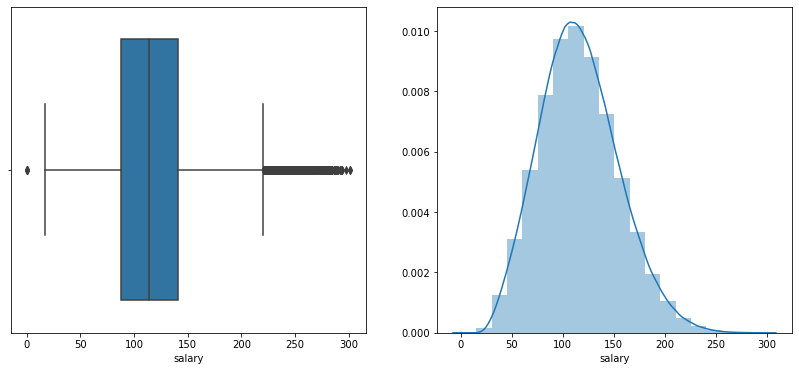

In [20]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_df.salary)
plt.subplot(1,2,2)
sns.distplot(train_df.salary, bins=20)
plt.show()

In [21]:
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [22]:
#check potential outlier below lower bound
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [23]:
#Delete the zero salary rows
train_df = train_df[train_df.salary > 8.5]

In [24]:
#check potential outlier above upper bound
train_df.loc[train_df.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

In [25]:
# Check most suspicious potential outliers above upper bound
train_df[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


__Plotting features against target variable__

In [26]:
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

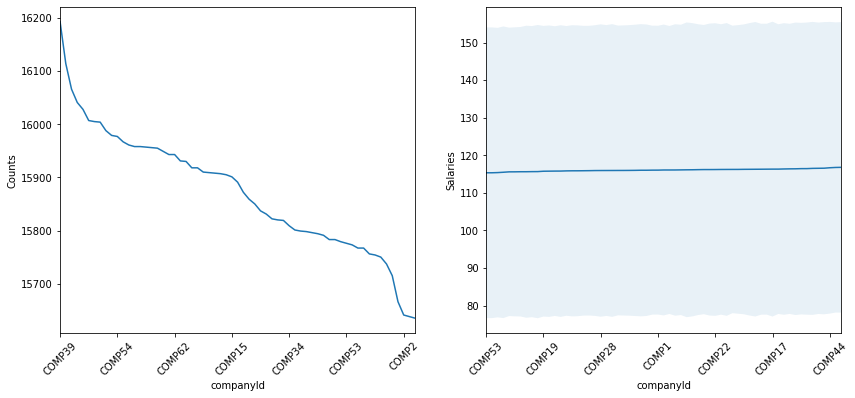

In [27]:
plot_feature(train_df, 'companyId')

__CompanyID is weakly correlated with Salary and there is no obvious trend.__

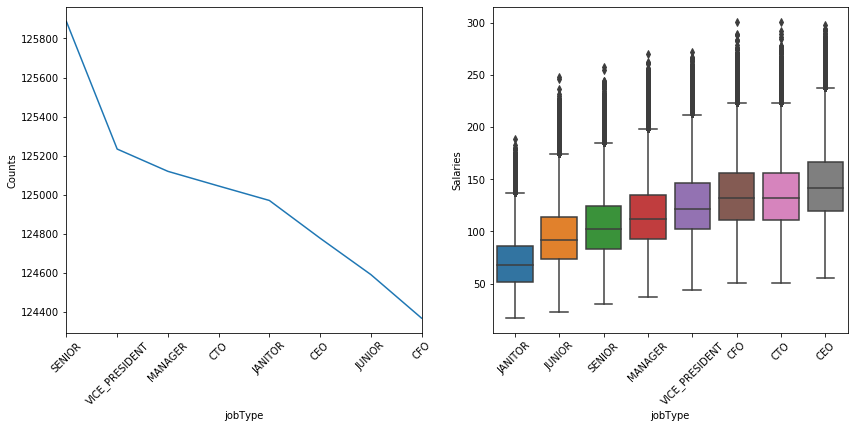

In [28]:
plot_feature(train_df, 'jobType')

__There is a clear positive correlation between jobType and salary. The salaries seem to increase with the level of seniority. The highest paid employees are senior executives. The lowest salary is for the jobtype Janitor.__

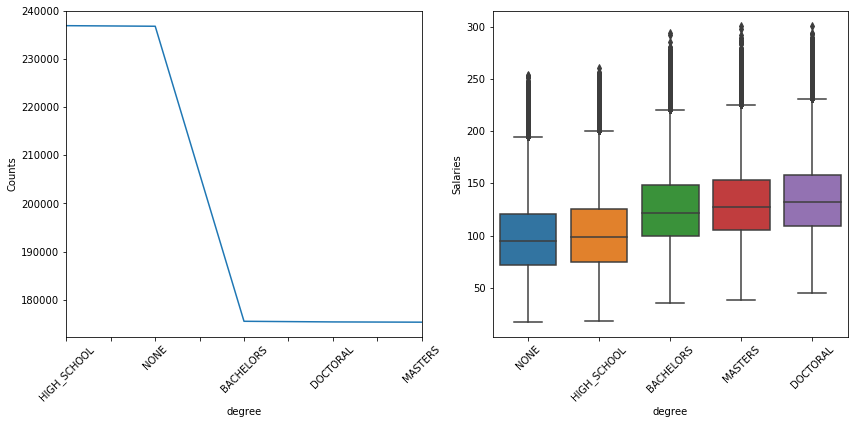

In [29]:
plot_feature(train_df, 'degree')

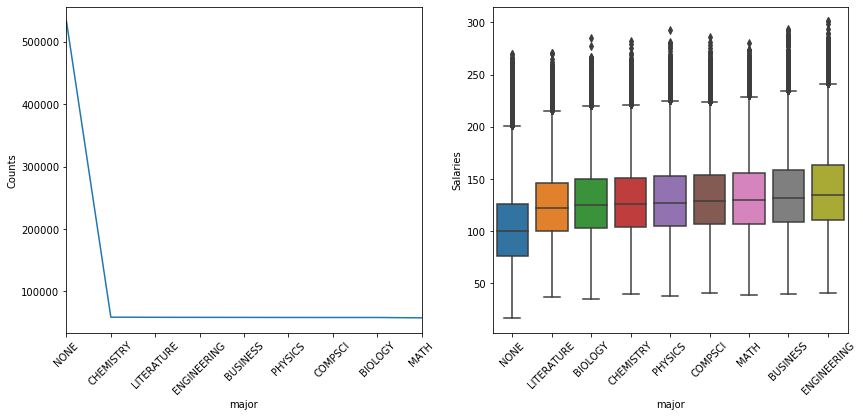

In [30]:
plot_feature(train_df, 'major')

__People with majors of engineering, business and math generally have higher salaries.__

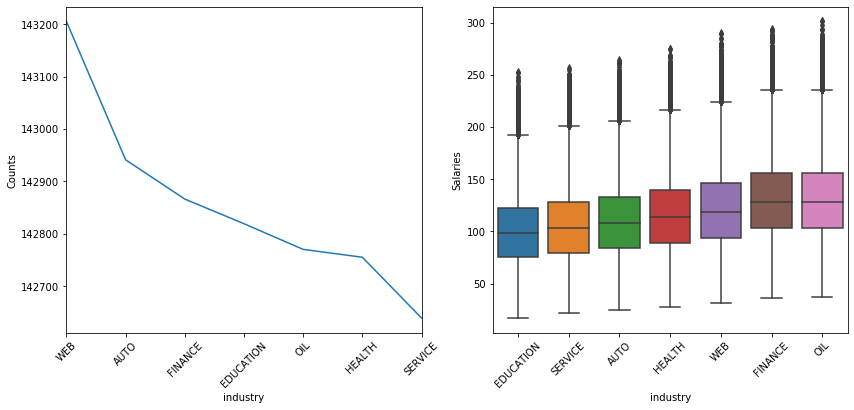

In [31]:
plot_feature(train_df, 'industry')

__Employees working in Oil, Finance and Web industries tend to earn more than the other industries.__

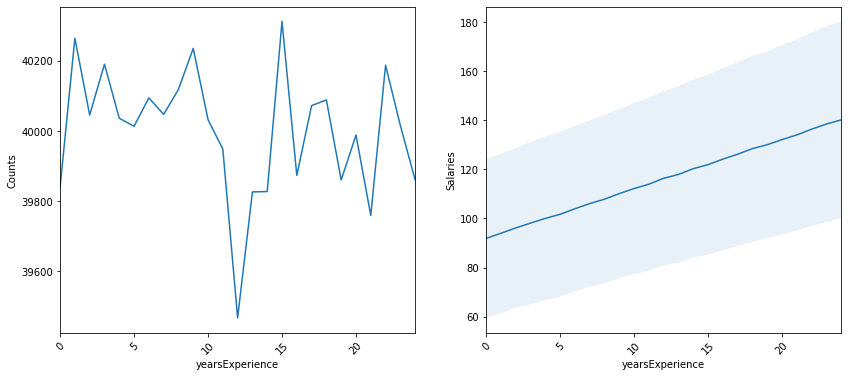

In [32]:
plot_feature(train_df, 'yearsExperience')

__In general, there is a clear positive correlation between salary and years of experience.__

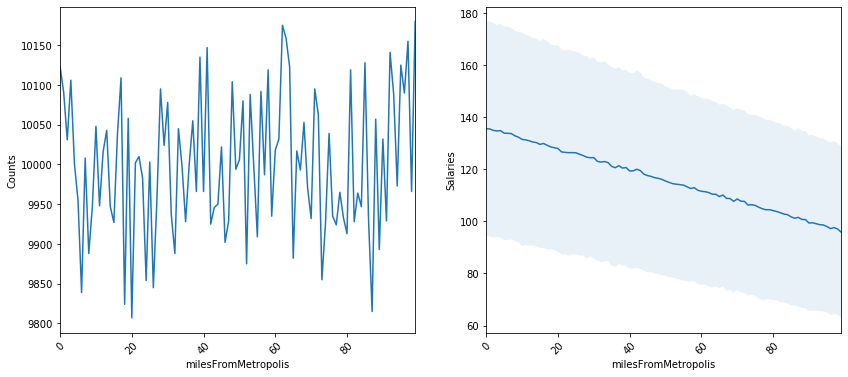

In [33]:
plot_feature(train_df, 'milesFromMetropolis')

__In general, there is a clear negative correlation between salary and milesFromMetropolis. The farther from metro, lower the salary.__

In [34]:
# drop jobId and companyId 
train_df.drop(['jobId'], axis = 1, inplace = True)
train_df.drop(['companyId'], axis = 1, inplace = True)

__Now dummy variables will be assigned to categorical data ("one-hot encoding") so it can be used in the prediction models.__ 

In [35]:
## One-hot encode categorical data in clean_train_df dataset
train_df = pd.get_dummies(train_df, drop_first = True)

In [36]:
train_df.sample(5)

,yearsExperience,milesFromMetropolis,salary,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,jobType_CEO,...,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
257048,13,28,169,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1889,16,29,144,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
749923,14,15,185,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
953397,17,16,133,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255464,4,22,168,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### Correlation between all the features

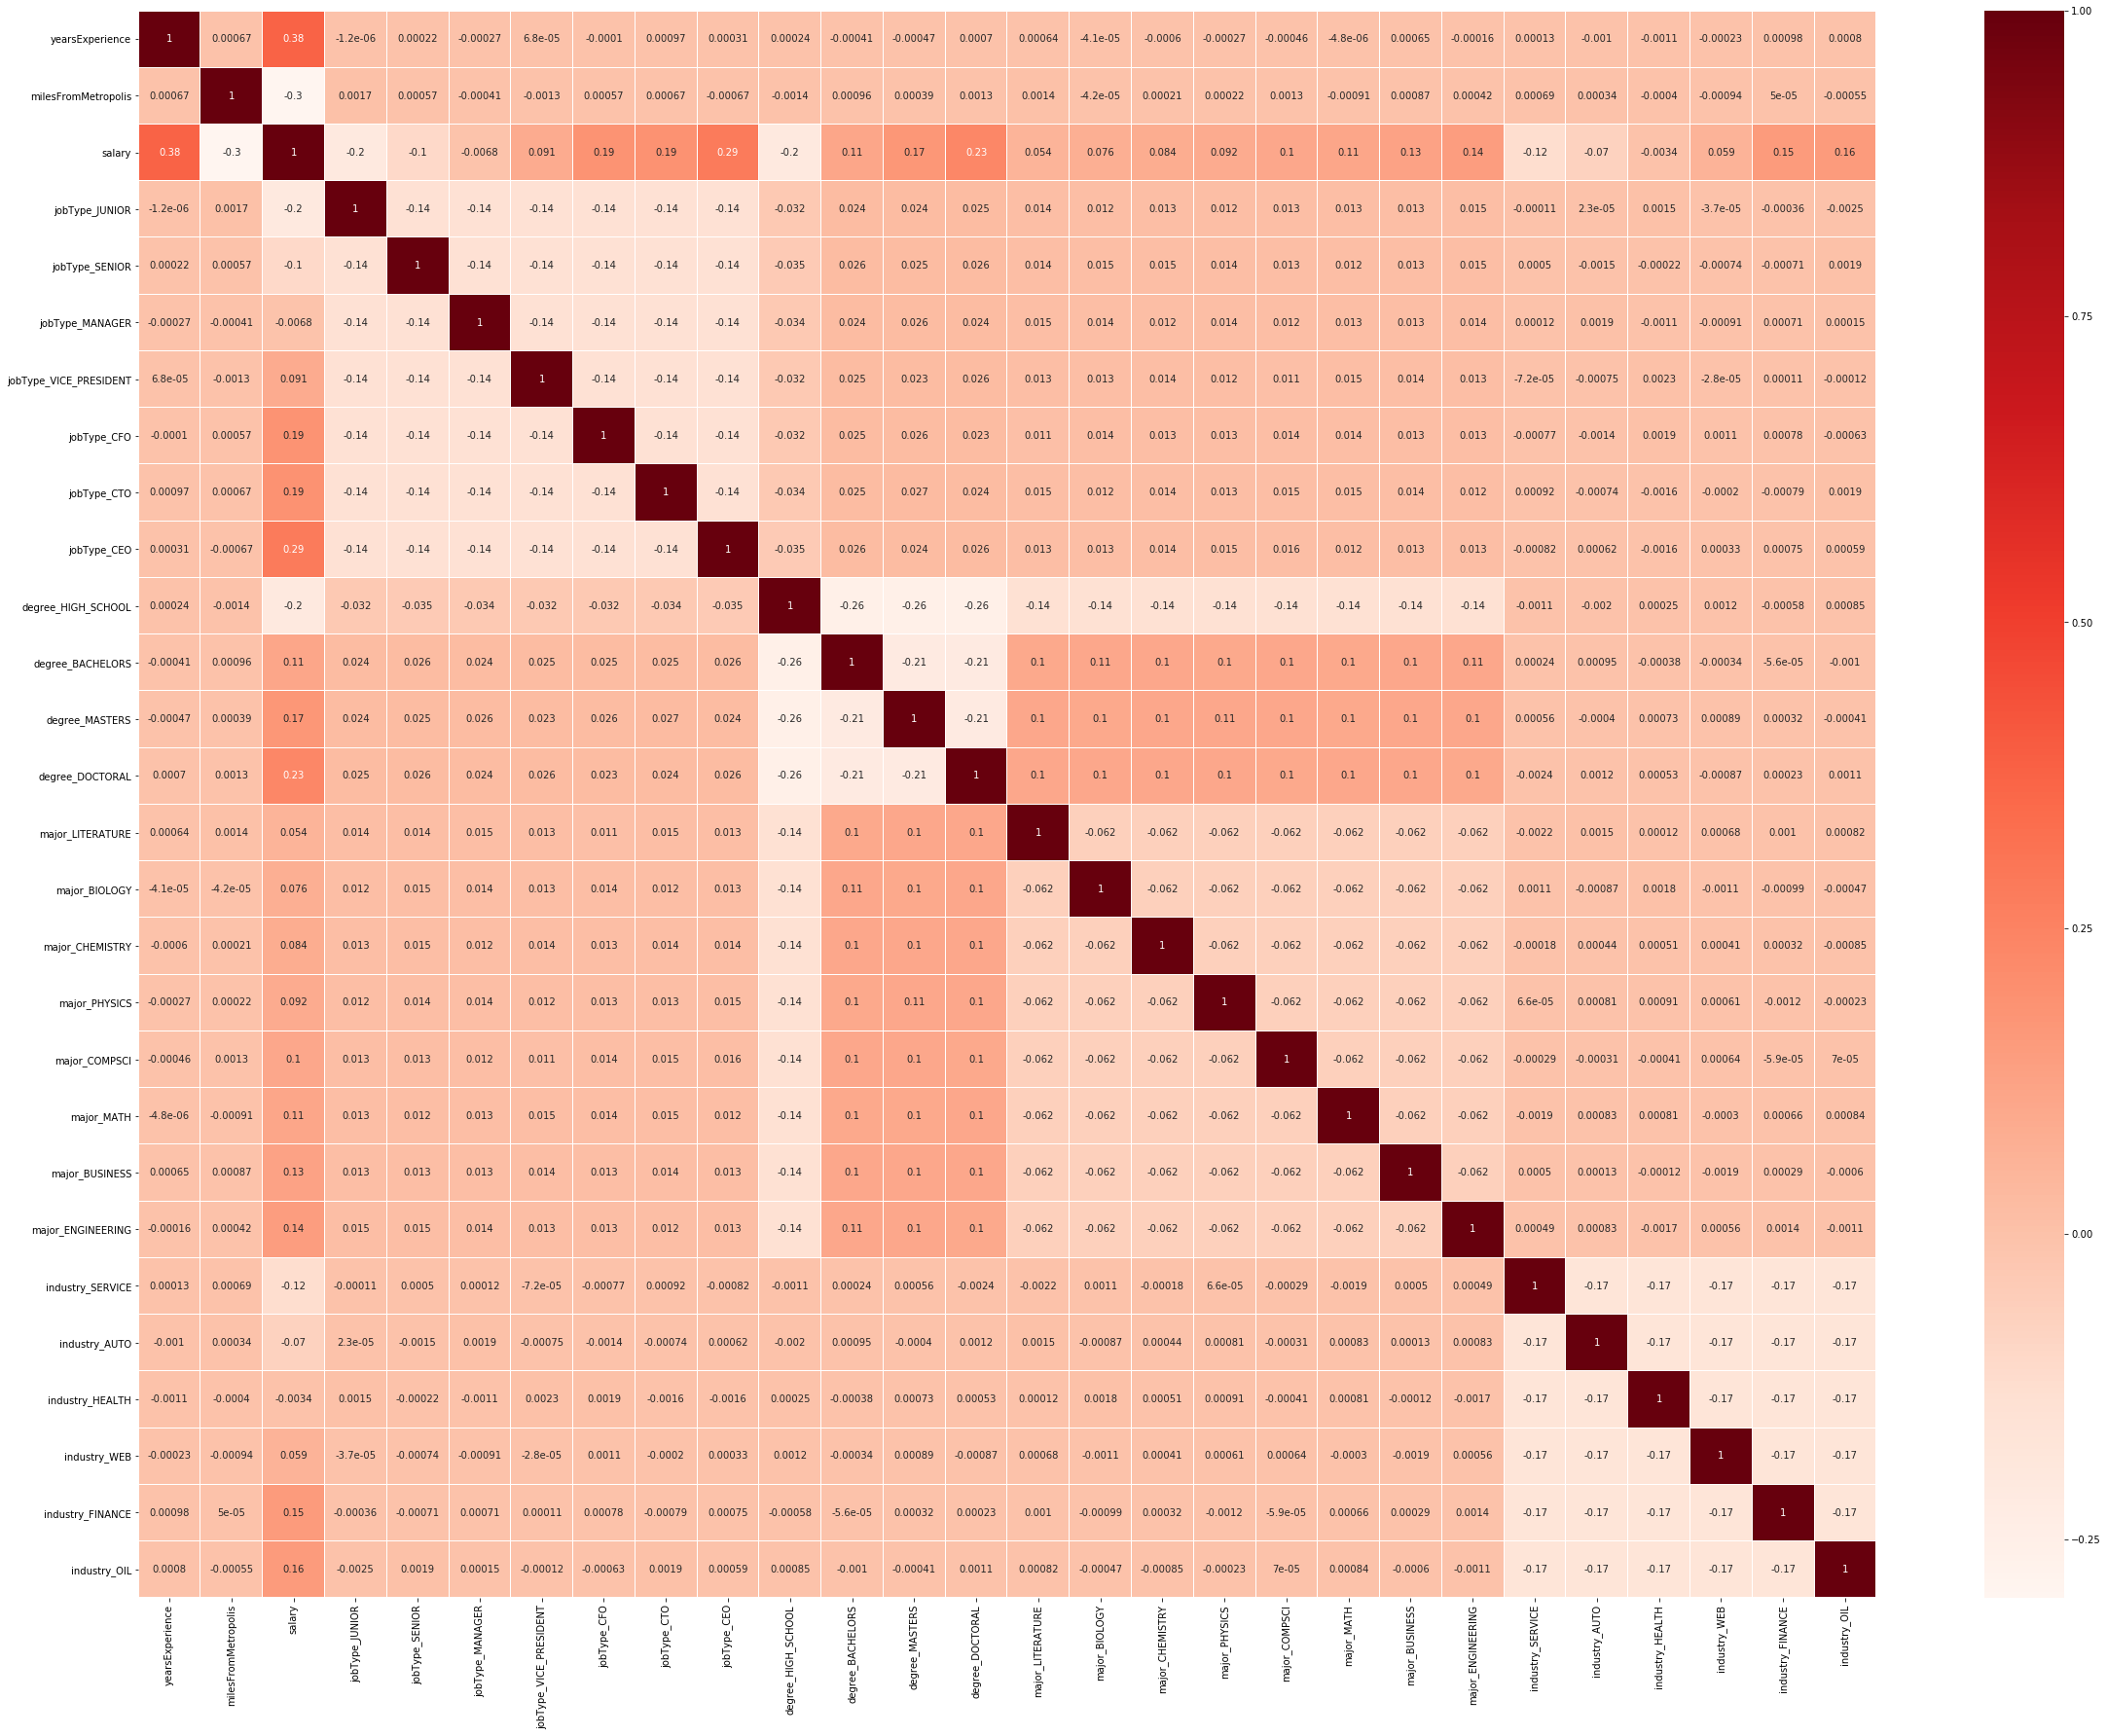

In [37]:
# Plot heatmap of all data with correlation coefficients visible
train_df_corr = train_df.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(train_df_corr, cmap = 'Reds', linewidth =.005, annot = True)

In [38]:
train_df.corr()['salary'].sort_values(ascending = False)

salary                    1.000000
yearsExperience           0.375013
jobType_CEO               0.285246
degree_DOCTORAL           0.231406
jobType_CTO               0.189608
jobType_CFO               0.188803
degree_MASTERS            0.171997
industry_OIL              0.156966
industry_FINANCE          0.154853
major_ENGINEERING         0.144203
major_BUSINESS            0.126123
degree_BACHELORS          0.111919
major_MATH                0.110413
major_COMPSCI             0.102986
major_PHYSICS             0.092056
jobType_VICE_PRESIDENT    0.090947
major_CHEMISTRY           0.084044
major_BIOLOGY             0.076339
industry_WEB              0.058953
major_LITERATURE          0.053918
industry_HEALTH          -0.003445
jobType_MANAGER          -0.006778
industry_AUTO            -0.069904
jobType_SENIOR           -0.103650
industry_SERVICE         -0.122370
jobType_JUNIOR           -0.201987
degree_HIGH_SCHOOL       -0.203549
milesFromMetropolis      -0.297686
Name: salary, dtype:

In [39]:
variables = train_df.drop(['salary'],axis=1)
vif = pd.DataFrame()

__Checking for multicollinearity and getting rid of it.__

In [40]:
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,3.289527,yearsExperience
1,3.411200,milesFromMetropolis
2,1.846013,jobType_JUNIOR
3,1.856352,jobType_SENIOR
4,1.849757,jobType_MANAGER
5,1.851556,jobType_VICE_PRESIDENT
6,1.846153,jobType_CFO
7,1.850799,jobType_CTO
8,1.848322,jobType_CEO
9,1.806496,degree_HIGH_SCHOOL


__Rule of thumb is to have VIF < 5 to avoid multicollinearity. From the above VIF(s) we can see that there is no obvious multicollinearity, so we do not drop any features.__

__Split the data into train and test sets.__

In [41]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
features = train_df.drop(['salary'],axis=1)
target = train_df['salary']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(799996, 27) (799996,)
(199999, 27) (199999,)


In [42]:
models= []
mean_mse = {}
cv_std = {}
res = {}

def train_model(model, feature_df, target_df, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, max_depth=25, min_samples_split=60, \
                           max_features=20, verbose=0)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=0)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, features, target, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.43162855496985
Standard deviation during CV:
 1.4003333110451877

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4316285549698
Standard deviation during CV:
 1.4003333110448466

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=20, max_leaf_nodes=None,
                      max_